In [7]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [8]:
import argparse
import pandas as pd
import lightgbm as lgb
import joblib
from sklearn.preprocessing import StandardScaler
import copy
# import random
import itertools
from sklearn.impute import SimpleImputer
import numpy as np

In [9]:
def preprocess_data(df):
    # # 假设需要对数据进行标准化
    # scaler = StandardScaler()
    # data_scaled = scaler.fit_transform(data)
    # Count the frequency of k-mer in each RNA sequence
        # k-mer was normalized by total k-mer count of each RNA sequence
    def _count_kmer(Dataset, k):  # k = 3, 4, 5
        
        # copy dataset
        dataset = copy.deepcopy(Dataset)
        # alphabet of nucleotide
        nucleotide = ['A', 'C', 'G', 'T']
        
        # generate k-mers
        #  k == 5:
        five = list(itertools.product(nucleotide, repeat=5))
        pentamer = [''.join(n) for n in five]
        
        #  k == 4:
        four = list(itertools.product(nucleotide, repeat=4))
        tetramer = [''.join(n) for n in four]

        # k == 3:
        three = list(itertools.product(nucleotide, repeat=3))
        threemer = [''.join(n) for n in three]
        
        # input features can be combinations of different k values
        if k == 34:
            table_kmer = dict.fromkeys(threemer, 0)
            table_kmer.update(dict.fromkeys(tetramer, 0))
        elif k == 45:
            table_kmer = dict.fromkeys(tetramer, 0)
            table_kmer.update(dict.fromkeys(pentamer, 0))
        elif k == 345:
            table_kmer = dict.fromkeys(threemer, 0)
            table_kmer.update(dict.fromkeys(tetramer, 0))
            table_kmer.update(dict.fromkeys(pentamer, 0))

        # count k-mer for each sequence
        for mer in table_kmer.keys():
            table_kmer[mer] = dataset["sequence"].apply(lambda x: x.count(mer))
        
        # for k-mer raw count without normalization, index: nuc:1 or cyto:0
        rawcount_kmer_df = pd.DataFrame(table_kmer)
        df1_rawcount = pd.concat([rawcount_kmer_df, dataset["name"]], axis=1)
        df1_rawcount.index = dataset["tag"]

        # for k-mer frequency with normalization, index: nuc:1 or cyto:0
        freq_kmer_df = rawcount_kmer_df.apply(lambda x: x / x.sum(), axis=1)
        df1 = pd.concat([freq_kmer_df, dataset["name"]], axis=1)
        df1.index = dataset["tag"]

        return df1, df1_rawcount

    df_kmer_test, df_kmer_test_raw = _count_kmer(df, 345)
    del df_kmer_test['name']
    x_kmer = df_kmer_test.values
    imputer = SimpleImputer(strategy='mean')
    x_test = imputer.fit_transform(x_kmer)
    # y_test = np.array(df_kmer_test.index)

    return x_test

In [10]:
def load_model(model_path):
    model = joblib.load(model_path)
    return model

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score, matthews_corrcoef

def predict(model, x_test, df):
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:,1]
    df['prediction'] = y_pred  # 添加预测标签列
    df['prob'] = y_prob  # 添加预测概率列

    evaluate_df = df

    auroc = roc_auc_score(evaluate_df["tag"], evaluate_df["prob"])
    auprc = average_precision_score(evaluate_df["tag"], evaluate_df["prob"])
    accuracy = accuracy_score(evaluate_df['tag'], evaluate_df['prediction'])
    f1 = f1_score(evaluate_df['tag'], evaluate_df['prediction'])
    mcc = matthews_corrcoef(evaluate_df['tag'], evaluate_df['prediction'])
    recall = recall_score(evaluate_df['tag'], evaluate_df['prediction'])
    precision = precision_score(evaluate_df['tag'], evaluate_df['prediction'])
    print(f"AUROC: {auroc:.4f}")
    print(f"AUPRC: {auprc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    
    return evaluate_df

In [12]:
def parse_fasta_to_dataframe(fasta_path):
    records = []
    with open(fasta_path, 'r') as file:
        name, tag, seq_lines = None, None, []
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if name:
                    sequence = ''.join(seq_lines)
                    records.append({'name': name, 'tag': tag, 'sequence': sequence})
                # 处理新的记录
                header = line[1:]  # 去掉'>'符号
                # 从header中提取name和tag（分割最后一个下划线）
                if '_' in header:
                    # 找到最后一个下划线的位置
                    last_underscore_index = header.rfind('_')
                    name = header[:last_underscore_index]  # 下划线之前的部分作为name
                    tag_str = header[last_underscore_index + 1:]  # 下划线之后的部分作为tag
                    try:
                        tag = int(tag_str)  # 将tag转换为整数
                    except ValueError:
                        tag = None  # 如果转换失败，设为None
                else:
                    name = header
                    tag = None
                seq_lines = []
            else:
                seq_lines.append(line)
        # 添加最后一条记录
        if name:
            sequence = ''.join(seq_lines)
            records.append({'name': name, 'tag': tag, 'sequence': sequence})
    
    return pd.DataFrame(records)
# def parse_fasta_to_dataframe(fasta_path):
#     records = []
#     with open(fasta_path, 'r') as file:
#         name, position, seq_lines = None, None, []
#         for line in file:
#             line = line.strip()
#             if line.startswith('>'):
#                 if name:
#                     sequence = ''.join(seq_lines)
#                     tag = 0 if position in ['Nucleus', 'Cytosol'] else 1
#                     records.append({'name': name, 'position': position, 'sequence': sequence, 'tag': tag})
#                 # 处理新的记录
#                 header_parts = line[1:].split()
#                 name = header_parts[0]
#                 position = header_parts[1] if len(header_parts) > 1 else 'Unknown'
#                 seq_lines = []
#             else:
#                 seq_lines.append(line)
#         # 添加最后一条记录
#         if name:
#             sequence = ''.join(seq_lines)
#             tag = 0 if position in ['Nucleus', 'Cytosol'] else 1
#             records.append({'name': name, 'position': position, 'sequence': sequence, 'tag': tag})
    
#     return pd.DataFrame(records)

In [13]:
model = load_model('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/RandomForest/best_RandomForest_model.pkl')
df = parse_fasta_to_dataframe('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/test_set_sequences.fasta')
x_test = preprocess_data(df)
evaluate_df = predict(model, x_test, df)


AUROC: 0.7432
AUPRC: 0.7842
Accuracy: 0.6831
F1 Score: 0.6848
MCC: 0.3661
Recall: 0.6885
Precision: 0.6811


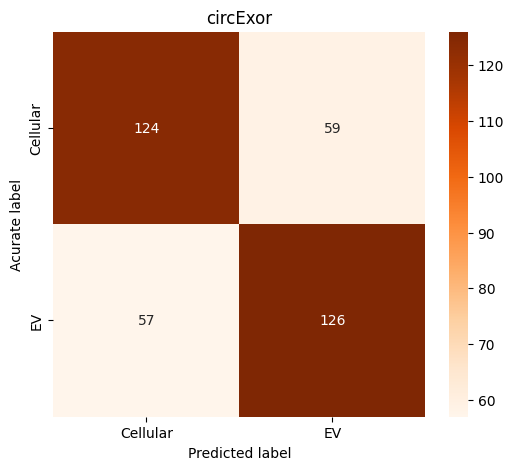

In [14]:
cm = confusion_matrix(evaluate_df['tag'], evaluate_df['prediction'])

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cellular', 'EV'], yticklabels=['Cellular', 'EV'])
plt.title('circExor')
plt.ylabel('Acurate label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
# 反事实突变，ev kmer突变
model = load_model('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/RandomForest/best_RandomForest_model.pkl')
df = parse_fasta_to_dataframe('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/SHAP/test_EV_sequences_mutated.fasta')
x_test = preprocess_data(df)
evaluate_df = predict(model, x_test, df)

AUROC: 0.3999
AUPRC: 0.4372
Accuracy: 0.4344
F1 Score: 0.2527
MCC: -0.1501
Recall: 0.1913
Precision: 0.3723


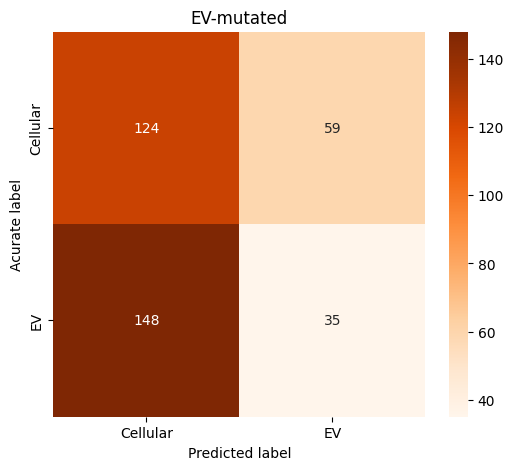

In [16]:
cm = confusion_matrix(evaluate_df['tag'], evaluate_df['prediction'])
# cm_normalized = normalize(cm, norm='l1', axis=1)

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=cm, fmt='d', cmap='Oranges', xticklabels=['Cellular', 'EV'], yticklabels=['Cellular', 'EV'])
plt.title('EV-mutated')
plt.ylabel('Acurate label')
plt.xlabel('Predicted label')
plt.show()


In [17]:
# 反事实突变，cyto kmer突变
model = load_model('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/RandomForest/best_RandomForest_model.pkl')
df = parse_fasta_to_dataframe('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/SHAP/test_Cyto_sequences_mutated.fasta')
x_test = preprocess_data(df)
evaluate_df = predict(model, x_test, df)

AUROC: 0.7532
AUPRC: 0.7958
Accuracy: 0.6940
F1 Score: 0.6923
MCC: 0.3880
Recall: 0.6885
Precision: 0.6961


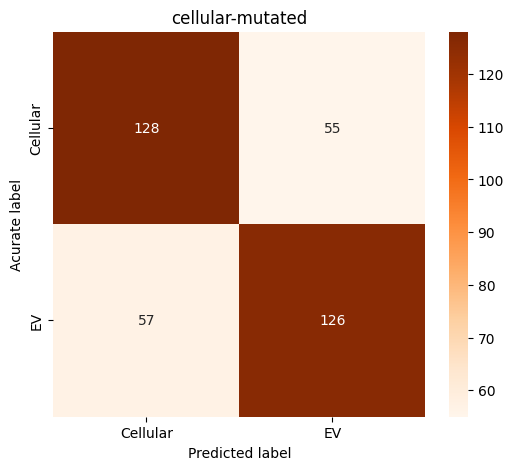

In [18]:
cm = confusion_matrix(evaluate_df['tag'], evaluate_df['prediction'])
# cm_normalized = normalize(cm, norm='l1', axis=1)

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=cm, fmt='d', cmap='Oranges', xticklabels=['Cellular', 'EV'], yticklabels=['Cellular', 'EV'])
plt.title('cellular-mutated')
plt.ylabel('Acurate label')
plt.xlabel('Predicted label')
plt.show()

AUROC: 0.7432
AUPRC: 0.7842
Accuracy: 0.6831
F1 Score: 0.6848
MCC: 0.3661
Recall: 0.6885
Precision: 0.6811
AUROC: 0.3999
AUPRC: 0.4372
Accuracy: 0.4344
F1 Score: 0.2527
MCC: -0.1501
Recall: 0.1913
Precision: 0.3723
AUROC: 0.7532
AUPRC: 0.7958
Accuracy: 0.6940
F1 Score: 0.6923
MCC: 0.3880
Recall: 0.6885
Precision: 0.6961


/tmp/ipykernel_151208/1664197417.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='Probability', data=df_violin_ev, inner='box', palette='pastel')


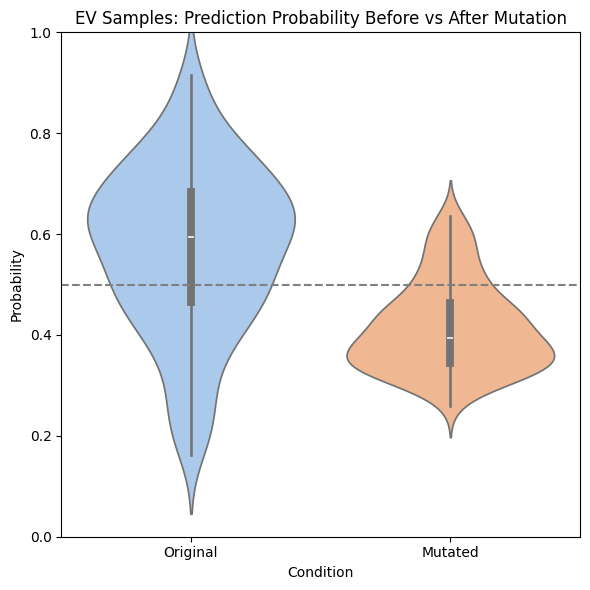

In [19]:
# 原始数据
df_orig = parse_fasta_to_dataframe('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/test_set_sequences.fasta')
x_orig = preprocess_data(df_orig)
evaluate_df_orig = predict(model, x_orig, df_orig)

# EV 突变
df_ev_mut = parse_fasta_to_dataframe('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/SHAP/test_EV_sequences_mutated.fasta')
x_ev_mut = preprocess_data(df_ev_mut)
evaluate_df_ev_mut = predict(model, x_ev_mut, df_ev_mut)

# CYTO 突变
df_cyto_mut = parse_fasta_to_dataframe('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/SHAP/test_Cyto_sequences_mutated.fasta')
x_cyto_mut = preprocess_data(df_cyto_mut)
evaluate_df_cyto_mut = predict(model, x_cyto_mut, df_cyto_mut)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 筛选正类样本（tag==1）
ev_orig = evaluate_df_orig[evaluate_df_orig['tag'] == 1]
ev_mut = evaluate_df_ev_mut[evaluate_df_ev_mut['tag'] == 1]

# 构建 DataFrame 供绘图
df_violin_ev = pd.DataFrame({
    'Original': ev_orig['prob'].values,
    'Mutated': ev_mut['prob'].values
})
df_violin_ev = df_violin_ev.melt(var_name='Condition', value_name='Probability')

# 绘图
plt.figure(figsize=(6, 6))
sns.violinplot(x='Condition', y='Probability', data=df_violin_ev, inner='box', palette='pastel')
plt.title('EV Samples: Prediction Probability Before vs After Mutation')
plt.axhline(0.5, linestyle='--', color='gray')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


/tmp/ipykernel_151208/49462611.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='Probability', data=df_violin_cyto, inner='box', palette='pastel')


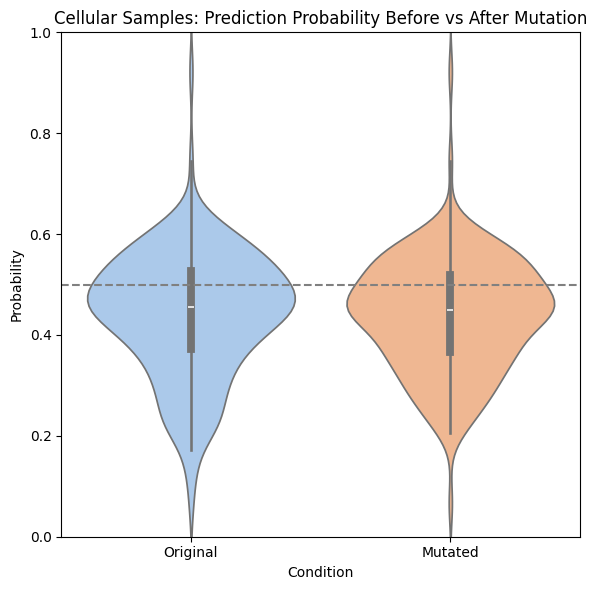

In [20]:
# 筛选负类样本（tag==0）
cyto_orig = evaluate_df_orig[evaluate_df_orig['tag'] == 0]
cyto_mut = evaluate_df_cyto_mut[evaluate_df_cyto_mut['tag'] == 0]

# 构建 DataFrame
df_violin_cyto = pd.DataFrame({
    'Original': cyto_orig['prob'].values,
    'Mutated': cyto_mut['prob'].values
})
df_violin_cyto = df_violin_cyto.melt(var_name='Condition', value_name='Probability')

# 绘图
plt.figure(figsize=(6, 6))
sns.violinplot(x='Condition', y='Probability', data=df_violin_cyto, inner='box', palette='pastel')
plt.title('Cellular Samples: Prediction Probability Before vs After Mutation')
plt.axhline(0.5, linestyle='--', color='gray')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [21]:
import numpy as np
from scipy.stats import shapiro, wilcoxon, ttest_rel

def comprehensive_paired_test(before, after, sample_name):
    """对配对数据进行全面的统计检验"""
    
    # 计算差值
    diff = after - before
    
    # 1. 正态性检验
    _, p_normal = shapiro(diff)
    print(f"\n{sample_name}样本:")
    print(f"差值正态性检验 p值: {p_normal:.4g}")
    
    # 2. 选择合适的检验方法
    if p_normal > 0.05:
        # 差值正态分布，使用配对t检验
        stat_t, p_t = ttest_rel(before, after)
        print(f"配对t检验 p值: {p_t:.4g}")
        primary_test = "配对t检验"
        primary_p = p_t
    else:
        primary_test = "Wilcoxon符号秩检验"
    
    # 3. Wilcoxon符号秩检验（非参数）
    stat_w, p_w = wilcoxon(before, after)
    print(f"Wilcoxon符号秩检验 p值: {p_w:.4g}")
    
    # 4. 描述性统计
    print(f"平均变化: {np.mean(diff):.4f}")
    print(f"中位数变化: {np.median(diff):.4f}")
    
    return primary_test, primary_p if 'primary_p' in locals() else p_w

# 对两组数据分别进行检验
comprehensive_paired_test(ev_orig['prob'], ev_mut['prob'], "EV")
comprehensive_paired_test(cyto_orig['prob'], cyto_mut['prob'], "Cellular")


EV样本:
差值正态性检验 p值: 0.0001094
Wilcoxon符号秩检验 p值: 4.395e-23
平均变化: -0.1548
中位数变化: -0.1141

Cellular样本:
差值正态性检验 p值: 3.587e-07
Wilcoxon符号秩检验 p值: 0.1405
平均变化: -0.0019
中位数变化: 0.0000


('Wilcoxon符号秩检验', 0.1405237852995186)